In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Q1 Local Binary Pattern (LBP)**

Accuracy: 63.33333333333333%


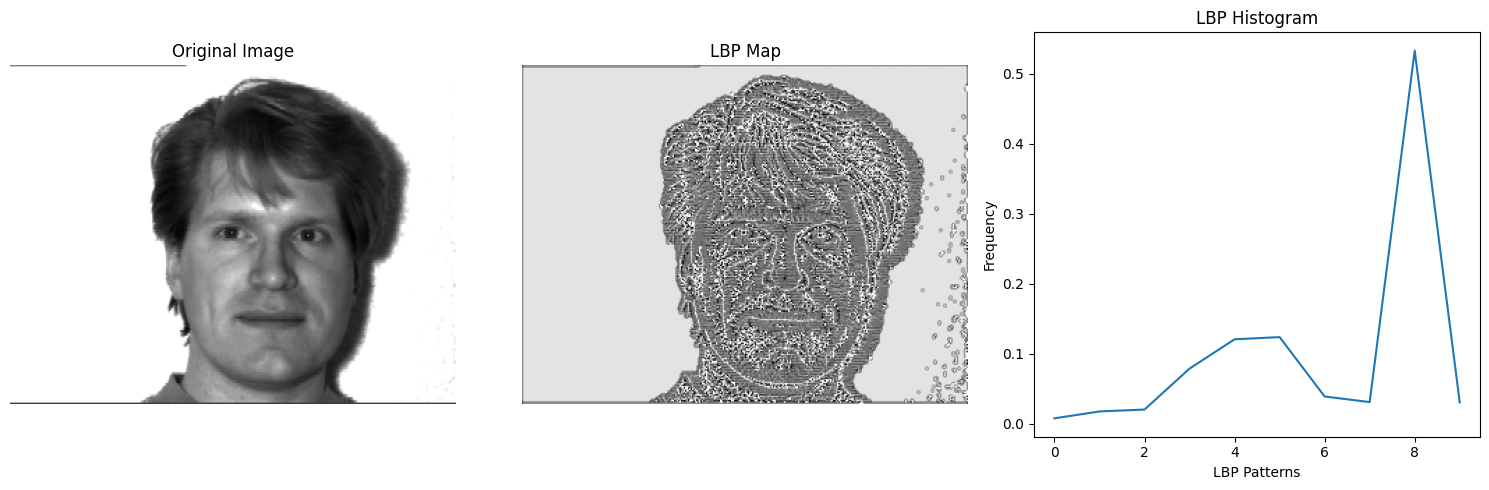

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from scipy.spatial.distance import euclidean

def load_images_with_pil(folder_path, image_extension='.gif'):
    images = []
    image_names = os.listdir(folder_path)
    for image_name in image_names:
        if image_name.endswith(image_extension):
            img = Image.open(os.path.join(folder_path, image_name)).convert('L')
            images.append((image_name, np.array(img)))
    return images


def apply_lbp_and_histogram(image, radius=1, n_points=8):
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    lbp_histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_histogram = lbp_histogram.astype("float32")
    lbp_histogram /= lbp_histogram.sum()
    return lbp, lbp_histogram


def extract_subject_id(image_name):
    return int(image_name.split('.')[0][7:])


def compute_euclidean_distance(hist1, hist2):
    return np.sqrt(np.sum((hist1 - hist2) ** 2))


def predict_subject(test_histogram, train_histograms):
    distances = [compute_euclidean_distance(test_histogram, train_histogram) for _, _, train_histogram in train_histograms]
    predicted_id_index = np.argmin(distances)
    return predicted_id_index

train_folder_path = '/content/drive/MyDrive/AIP Assignment/train-20250205T033219Z-001/train'
test_folder_path = '/content/drive/MyDrive/AIP Assignment/test-20250205T033211Z-001/test'

train_images = load_images_with_pil(train_folder_path)
test_images = load_images_with_pil(test_folder_path)


train_lbp_data = []
for image_name, img in train_images:
    lbp_map, lbp_histogram = apply_lbp_and_histogram(img, radius=1, n_points=8)
    train_lbp_data.append((image_name, lbp_map, lbp_histogram))


test_lbp_data = []
for image_name, img in test_images:
    lbp_map, lbp_histogram = apply_lbp_and_histogram(img, radius=1, n_points=8)
    test_lbp_data.append((image_name, lbp_map, lbp_histogram))


train_subject_map = {i: extract_subject_id(image_name) for i, (image_name, _, _) in enumerate(train_lbp_data)}


correct_predictions = 0
total_predictions = len(test_lbp_data)


for i, (_, _, test_histogram) in enumerate(test_lbp_data):
    predicted_id_index = predict_subject(test_histogram, train_lbp_data)


    true_id = extract_subject_id(test_lbp_data[i][0])

    predicted_id = extract_subject_id(train_lbp_data[predicted_id_index][0])

    if predicted_id == true_id:
        correct_predictions += 1

accuracy = (correct_predictions / len(test_lbp_data)) * 100
print(f"Accuracy: {accuracy}%")

example_image_name, example_lbp_map, example_lbp_histogram = test_lbp_data[0]


fig, ax = plt.subplots(1, 3, figsize=(15, 5))


ax[0].imshow(test_images[0][1], cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")


ax[1].imshow(example_lbp_map, cmap='gray')
ax[1].set_title("LBP Map")
ax[1].axis("off")


ax[2].plot(example_lbp_histogram)
ax[2].set_title("LBP Histogram")
ax[2].set_xlabel("LBP Patterns")
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


**2.Extracting Knowledge from Networks**

Q 2.(a)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image = self.data[idx].reshape(3, 32, 32)
        label = self.labels[idx]


        image = np.transpose(image, (1, 2, 0))

        if self.transform:
            image = self.transform(image)

        return image, label

def preprocess_data(data, labels):
    data = data.reshape(-1, 3, 32, 32).astype(np.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    return data, labels

def load_cifar10_data(path):
    data_batches = []
    labels_batches = []
    batch_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']

    for batch_file in batch_files:
        with open(os.path.join(path, batch_file), 'rb') as f:
            batch = pickle.load(f, encoding='latin1')
            data_batches.append(batch['data'])
            labels_batches.append(batch['labels'])

    data = np.vstack(data_batches)
    labels = np.hstack(labels_batches)

    test_batch_file = os.path.join(path, 'test_batch')
    with open(test_batch_file, 'rb') as f:
        test_batch = pickle.load(f, encoding='latin1')
        test_data = test_batch['data']
        test_labels = np.array(test_batch['labels'])

    return data, labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = load_cifar10_data('/content/drive/MyDrive/AIP Assignment/cifar-10-python/cifar-10-batches-py')

train_data_processed, train_labels_processed = preprocess_data(train_data, train_labels)
test_data_processed, test_labels_processed = preprocess_data(test_data, test_labels)

train_dataset = CIFAR10Dataset(train_data_processed, train_labels_processed, transform=transform)
test_dataset = CIFAR10Dataset(test_data_processed, test_labels_processed, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class ResNet50Finetune(nn.Module):
    def __init__(self):
        super(ResNet50Finetune, self).__init__()
        self.model = models.resnet50(weights='IMAGENET1K_V1')
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

resnet50_model = ResNet50Finetune().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, criterion, optimizer, num_epochs=1):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {epoch_acc}%')

train_model(resnet50_model, criterion, optimizer, num_epochs=20)

Epoch 1/20, Loss: 0.9392412629405124, Accuracy: 67.9%
Epoch 2/20, Loss: 0.5272841638219867, Accuracy: 81.98%
Epoch 3/20, Loss: 0.36893784643764, Accuracy: 87.416%
Epoch 4/20, Loss: 0.265636331927906, Accuracy: 90.8%
Epoch 5/20, Loss: 0.19190545147612587, Accuracy: 93.408%
Epoch 6/20, Loss: 0.1510477854988835, Accuracy: 94.902%
Epoch 7/20, Loss: 0.11596965074529651, Accuracy: 96.044%
Epoch 8/20, Loss: 0.08942646559110949, Accuracy: 96.986%
Epoch 9/20, Loss: 0.07363812570835232, Accuracy: 97.522%
Epoch 10/20, Loss: 0.06503997055352032, Accuracy: 97.782%
Epoch 11/20, Loss: 0.05126445475037395, Accuracy: 98.29%
Epoch 12/20, Loss: 0.04615974032163074, Accuracy: 98.488%
Epoch 13/20, Loss: 0.04298340298692885, Accuracy: 98.586%
Epoch 14/20, Loss: 0.035237198957959036, Accuracy: 98.84%
Epoch 15/20, Loss: 0.027861279329048992, Accuracy: 99.096%
Epoch 16/20, Loss: 0.02968431701195274, Accuracy: 99.008%
Epoch 17/20, Loss: 0.031393004548076, Accuracy: 98.932%
Epoch 18/20, Loss: 0.02785331687595193

In [ ]:
torch.save(resnet50_model.state_dict(), 'resnet50_finetune.pth')

In [ ]:
resnet50_model = ResNet50Finetune().to(device)

resnet50_model.load_state_dict(torch.load('resnet50_finetune.pth', weights_only=True))

resnet50_model.eval()

test_accuracy = evaluate_test_accuracy(resnet50_model, test_loader)
print(f'Test Accuracy on Test Split: {test_accuracy}%')


Test Accuracy on Test Split: 85.22%


**Q2.(b)**

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import numpy as np
import pickle

def load_cifar10_data(path):
    data_batches = []
    labels_batches = []
    batch_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']

    for batch_file in batch_files:
        with open(os.path.join(path, batch_file), 'rb') as f:
            batch = pickle.load(f, encoding='latin1')
            data_batches.append(batch['data'])
            labels_batches.append(batch['labels'])

    data = np.vstack(data_batches)
    labels = np.hstack(labels_batches)


    test_batch_file = os.path.join(path, 'test_batch')
    with open(test_batch_file, 'rb') as f:
        test_batch = pickle.load(f, encoding='latin1')
        test_data = test_batch['data']
        test_labels = np.array(test_batch['labels'])

    return data, labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = load_cifar10_data('/content/drive/MyDrive/AIP Assignment/cifar-10-python/cifar-10-batches-py')

def preprocess_data(data, labels):
    data = data.reshape(-1, 3, 32, 32).astype(np.float32)
    labels = to_categorical(labels, 10)
    return data, labels

train_data_processed, train_labels_processed = preprocess_data(train_data, train_labels)
test_data_processed, test_labels_processed = preprocess_data(test_data, test_labels)

train_data_processed, test_data_processed = train_data_processed / 255.0, test_data_processed / 255.0

train_data_processed = np.transpose(train_data_processed, (0, 2, 3, 1))
test_data_processed = np.transpose(test_data_processed, (0, 2, 3, 1))

def create_student_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model


student_model = create_student_model()
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

student_model.fit(train_data_processed, train_labels_processed, epochs=2, batch_size=64, validation_data=(test_data_processed, test_labels_processed))

test_loss, test_acc = student_model.evaluate(test_data_processed, test_labels_processed, verbose=2)
print(f"Test Accuracy of the Student Model: {test_acc * 100:.2f}%")


Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 175ms/step - accuracy: 0.3811 - loss: 1.6929 - val_accuracy: 0.6236 - val_loss: 1.0654
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - accuracy: 0.6497 - loss: 0.9962 - val_accuracy: 0.6813 - val_loss: 0.9050
313/313 - 6s - 20ms/step - accuracy: 0.6813 - loss: 0.9050
Test Accuracy of the Student Model: 68.13%


**Q2.(c)**

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

def create_student_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_teacher_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(10, activation='softmax')
    ])
    return model

def kl_divergence_loss(p, q, temperature=3):
    p = tf.nn.softmax(p / temperature)
    q = tf.nn.softmax(q / temperature)
    return tf.reduce_mean(tf.reduce_sum(p * tf.math.log(p / (q + 1e-9)), axis=-1))

def distillation_loss(y_true, y_pred, teacher_logits, alpha=0.5, temperature=3):
    ce_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    kl_loss = kl_divergence_loss(teacher_logits, y_pred, temperature)
    return ce_loss + alpha * kl_loss

def train_with_distillation(student, teacher, x_train, y_train, x_test, y_test, epochs=10, batch_size=64, alpha=0.5, temperature=3):
    student.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    teacher.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    teacher.fit(x_train, y_train, epochs=10, batch_size=batch_size, validation_data=(x_test, y_test))

    for epoch in range(epochs):
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            teacher_logits = teacher(x_batch, training=False)

            with tf.GradientTape() as tape:

                student_logits = student(x_batch, training=True)

                loss = distillation_loss(y_batch, student_logits, teacher_logits, alpha=alpha, temperature=temperature)

            grads = tape.gradient(loss, student.trainable_variables)
            student.optimizer.apply_gradients(zip(grads, student.trainable_variables))

        student_accuracy = student.evaluate(x_test, y_test, verbose=0)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {student_accuracy[1]*100:.2f}%")

teacher_model = create_teacher_model()
student_model = create_student_model()

train_with_distillation(student_model, teacher_model, x_train, y_train, x_test, y_test, epochs=5, alpha=0.5, temperature=3)

test_loss, test_acc = student_model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy of the Student Model: {test_acc * 100:.2f}%")


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 237s 293ms/step - accuracy: 0.1916 - loss: 2.2136 - val_accuracy: 0.2994 - val_loss: 1.9525
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 262s 293ms/step - accuracy: 0.2909 - loss: 1.9580 - val_accuracy: 0.3238 - val_loss: 1.8821
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 259s 290ms/step - accuracy: 0.3193 - loss: 1.8971 - val_accuracy: 0.3389 - val_loss: 1.8494
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 261s 290ms/step - accuracy: 0.3376 - loss: 1.8534 - val_accuracy: 0.3203 - val_loss: 1.8550
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 226s 289ms/step - accuracy: 0.3458 - loss: 1.8314 - val_accuracy: 0.3496 - val_loss: 1.8507
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 262s 290ms/step - accuracy: 0.3594 - loss: 1.8087 - val_accuracy: 0.3592 - val_loss: 1.8092
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 261s 288ms/step - accuracy: 0.3574 - loss: 1.7981 - val_accuracy: 0.3754 - val_loss: 1.7657
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 257s 281ms/step - accuracy: 0.3723 -